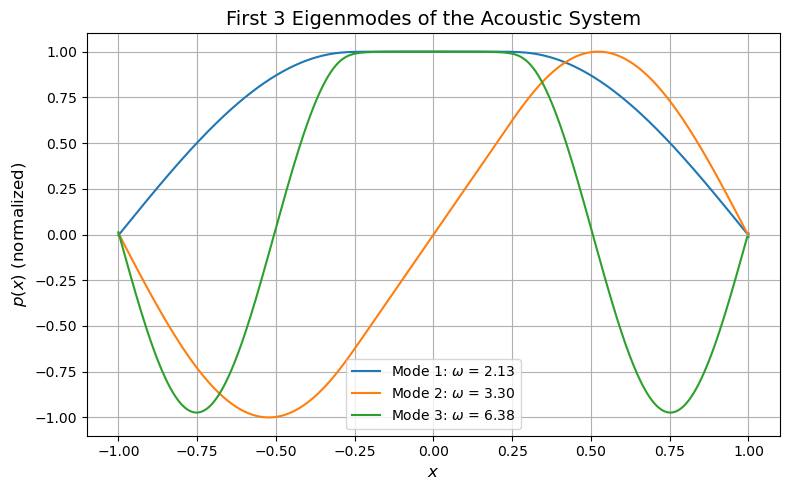

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.linalg import eigh

# Parameters
L = 1.0                       # Domain size [-L, L]
N = 500                       # Number of grid points
x = np.linspace(-L, L, N)     # Grid
dx = x[1] - x[0]              # Grid spacing

# Material parameters
rho0 = 1.                   # Background density
rhos = 1.                  # Solid density
K0 = 1.                    # Background bulk modulus (Pa)
Ks = 1e3                   # Solid bulk modulus (Pa)
phi = np.exp(-x**2 / 0.01)    # Smooth transition
rho = (1 - phi) * rho0 + phi * rhos
K = (1 - phi) * K0 + phi * Ks

# Construct 1/rho(x) and 1/K(x)
inv_rho = 1.0 / rho
inv_K = 1.0 / K

# Second derivative operator with Neumann BCs
main_diag = np.zeros(N)
off_diag = np.ones(N - 1)
D2 = diags([off_diag, -2 * np.ones(N), off_diag], offsets=[-1, 0, 1]) / dx**2
D2 = D2.toarray()

# Implement Neumann BCs (zero derivative at boundaries)
D2[0, 0:2] = [1, -1] / dx**2
D2[-1, -2:] = [-1, 1] / dx**2

# Stiffness matrix: M = -d/dx(1/rho * d/dx)
M = np.diag(inv_rho) @ D2

# Mass matrix: S = 1/K(x)
S = np.diag(inv_K)

# Solve generalized eigenvalue problem: M p = -omega^2 S p
eigvals, eigvecs = eigh(-M, S)

# Keep only positive eigenvalues (avoid small negative due to numerical error)
positive_idx = eigvals > 0
omega = np.sqrt(eigvals[positive_idx])
modes = eigvecs[:, positive_idx]

# Sort eigenfrequencies and modes
idx_sort = np.argsort(omega)
omega = omega[idx_sort]
modes = modes[:, idx_sort]

# Normalize first few modes
for i in range(3):
    modes[:, i] /= np.max(np.abs(modes[:, i]))

# Plot first 3 eigenmodes
plt.figure(figsize=(8, 5))
for i in range(3):
    plt.plot(x, modes[:, i], label=r'Mode {}: $\omega$ = {:.2f}'.format(i+1, omega[i]))
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$p(x)$ (normalized)', fontsize=12)
plt.title('First 3 Eigenmodes of the Acoustic System', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


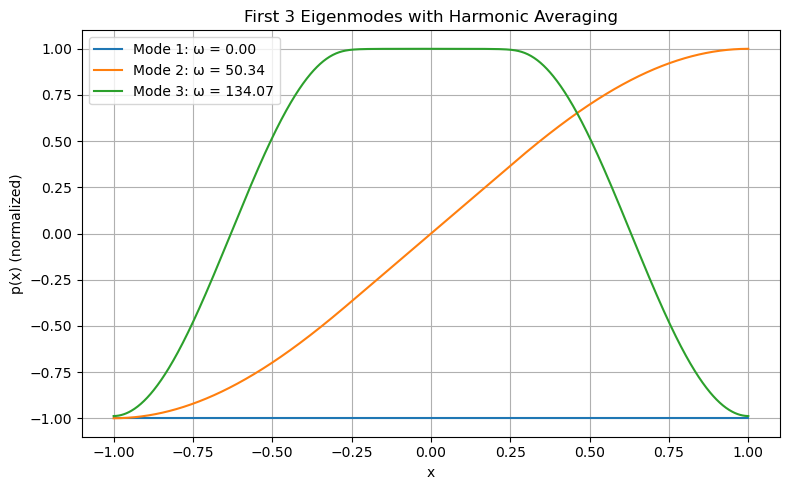

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Parameters
L = 1.0
N = 1000
x = np.linspace(-L, L, N)
dx = x[1] - x[0]

# Material parameters
rho0 = 1.
rhos = 1.
K0 = 1e3
Ks = 1e6
phi = np.exp(-x**2 / 0.01)
rho = (1 - phi) * rho0 + phi * rhos
K = (1 - phi) * K0 + phi * Ks

inv_rho = 1.0 / rho
inv_K = 1.0 / K

# Harmonic average of 1/rho at cell interfaces i+1/2
inv_rho_half = np.zeros(N-1)
for i in range(N-1):
    inv_rho_half[i] = 2 / (1/inv_rho[i] + 1/inv_rho[i+1])  # harmonic average

# Build diagonals
main_diag = np.zeros(N)
upper_diag = np.zeros(N-1)
lower_diag = np.zeros(N-1)

# Interior points
for i in range(1, N-1):
    main_diag[i] = -(inv_rho_half[i] + inv_rho_half[i-1]) / dx**2
    lower_diag[i-1] = inv_rho_half[i-1] / dx**2
    upper_diag[i] = inv_rho_half[i] / dx**2

# Boundary points (Neumann BCs)
# Left boundary (i=0)
main_diag[0] = -inv_rho_half[0] / dx**2
upper_diag[0] = inv_rho_half[0] / dx**2

# Right boundary (i=N-1)
main_diag[-1] = -inv_rho_half[-1] / dx**2
lower_diag[-1] = inv_rho_half[-1] / dx**2

# Assemble the matrix
M = np.diag(main_diag) + np.diag(upper_diag, k=1) + np.diag(lower_diag, k=-1)

# Mass matrix S
S = np.diag(inv_K)

# Solve generalized eigenvalue problem M p = -omega^2 S p
eigvals, eigvecs = eigh(-M, S)

# Filter positive eigenvalues
pos_idx = eigvals > 0
omega = np.sqrt(eigvals[pos_idx])
modes = eigvecs[:, pos_idx]
# Sort eigenvalues and eigenvectors
idx_sort = np.argsort(omega)
omega = omega[idx_sort]
modes = modes[:, idx_sort]
# Normalize first 3 modes
for i in range(3):
    modes[:, i] /= np.max(np.abs(modes[:, i]))

# Plot first 3 eigenmodes
plt.figure(figsize=(8,5))
for i in range(3):
    plt.plot(x, modes[:, i], label=f'Mode {i+1}: ω = {omega[i]:.2f}')
plt.xlabel('x')
plt.ylabel('p(x) (normalized)')
plt.title('First 3 Eigenmodes with Harmonic Averaging')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

